In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem.MolStandardize import rdMolStandardize

from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

from IPython.display import display, SVG, Image

# 1 Load input molecules/synthons

The input for molecules/synthons/fragments (names used interchangeably) expects a plain text file where each line is a SMILES string for a different molecule.

Additionally, the number of read in molecules can be limited by the ``num_lines`` option.

In [2]:
smiles_path = "Enamine_Fragment_Collection_259380cmpds_20230413.txt"
num_lines = -1
smiles = []

with open(smiles_path, "r") as f:
    for i, line in enumerate(f.readlines()):
        if i == num_lines:
            break

        # smiles.append(line[:-2])  # remove \t and \n characters
        smiles.append(line[:-1])  # remove \t and \n characters
        # smiles.append(line)

smiles = np.array(smiles)
print(f"Loaded {smiles.size} total molecules")
print(f"Loaded {smiles.nbytes / 1024 / 1024:.2f} MB worth of SMILES strings")

# # Select random set of smiles
# rng = np.random.default_rng(43)
# smiles = rng.choice(smiles, size=4096, replace=False)
# print(f"Selected {smiles.size} random molecules")

df_mols = pd.DataFrame({"SMILES": smiles})
df_mols

Loaded 259380 total molecules
Loaded 83.11 MB worth of SMILES strings


,SMILES
0,C1=CCNC1.Cl\t
1,CC1(N)CC1.Cl\t
2,Cl.OC1CNC1\t
3,c1nncs1\t
4,Nc1nnns1\t
...,...
259375,O=C1CCN(c2cc(C(=O)O)ccc2F)C(=O)N1\t
259376,FC(F)c1ncc2n1CCNC2\t
259377,O=C1CCN(c2cccc(C(=O)O)c2)C(=O)N1\t
259378,Cc1ccc(C(=O)O)cc1N1CCC(=O)NC1=O\t


## 1.1 Cleaning up molecules

In [3]:
# TODO: implement molecular filters, note that GDB-13 does not require any filters

def clean_up_mol(mol: Chem.Mol) -> Chem.Mol:
    """Cleans up a mol object, returning the cleaned mol. Currently implements:
    
    1. Largest Fragment Chooser
    2. Neutralize
    # 3. Remove Stereochemistry??
    """
    lf_chooser = Chem.MolStandardize.rdMolStandardize.LargestFragmentChooser(preferOrganic=True)
    uncharger = Chem.MolStandardize.rdMolStandardize.Uncharger()

    mol = lf_chooser.choose(mol)
    mol = uncharger.uncharge(mol)
    mol = Chem.RemoveHs(mol)

    return mol

mols = [Chem.MolFromSmiles(smi) for smi in smiles]
mols = [clean_up_mol(mol) for mol in mols]
mols = np.asarray(mols)

# Reassign SMILES strings to cleaned molecules 
df_mols["SMILES"] = [Chem.MolToSmiles(mol) for mol in tqdm(mols)]
df_mols

100%|██████████| 259380/259380 [00:10<00:00, 24883.61it/s]


,SMILES
0,C1=CCNC1
1,CC1(N)CC1
2,OC1CNC1
3,c1nncs1
4,Nc1nnns1
...,...
259375,O=C1CCN(c2cc(C(=O)O)ccc2F)C(=O)N1
259376,FC(F)c1ncc2n1CCNC2
259377,O=C1CCN(c2cccc(C(=O)O)c2)C(=O)N1
259378,Cc1ccc(C(=O)O)cc1N1CCC(=O)NC1=O


### Visualizing molecules on Grid

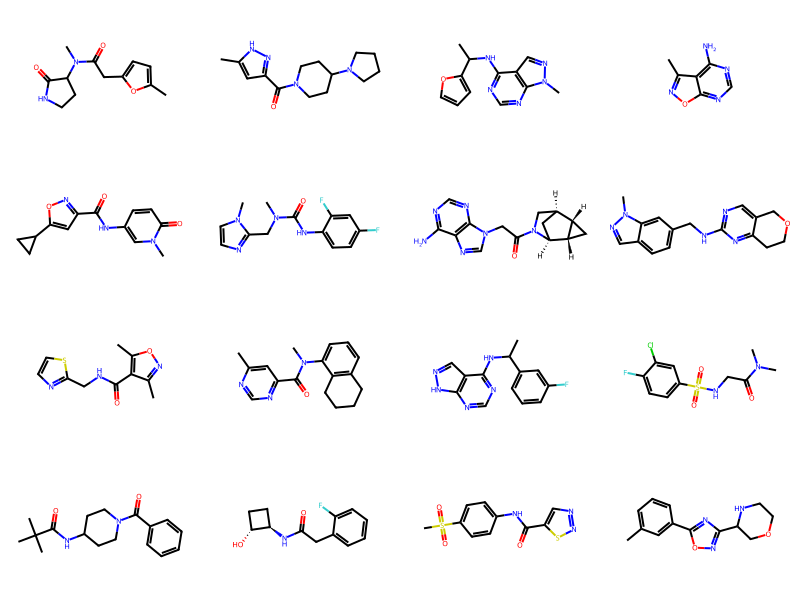

In [6]:
# Select random set of molecules
n_mols = 16
rng = np.random.default_rng()
idxs = rng.choice(np.arange(len(mols)), size=n_mols, replace=False, )


Chem.Draw.MolsToGridImage(
    mols[idxs],
    molsPerRow=4,
    maxMols=n_mols,
    subImgSize=(200, 150),
    useSVG=True,
)

# 2. Load DataFrame with reactions from csv file

Here, a ``.csv`` file with a ``"SMARTS"`` colum is loaded; other columns are allowed, although they are currently ignored in the workflow.
The following cells will identify the functional groups active in a reaction, label molecules with these functional groups (synthons), and format the reaction SMARTS so the CSLVAE will be happy.

<!--
The required columns in the DataFrame are ``"SMARTS"`` which is a string of the reaction SMARTS and ``"functional_groups"`` whose value is a list of integers corresponding to the index of the functional group (synonymously R group) involved in the reaction.
Also, another DataFrame is loaded which contains a SMARTS string of a functional group and that functional group's index
-->

In [7]:
df_reactions = pd.read_csv("custom_reactions2.csv")

df_reactions

,Unnamed: 0,reaction_name,url,SMARTS
0,0,Bartoli Indole Synthesis,http://www.name-reaction.com/bartoli-indole-sy...,"[c]1(-[$([NX3](=[O])=[O]),$([NX3+](=[O])[O-])]..."
1,1,Buchwald-Hartwig Amination,http://www.name-reaction.com/buchwald-hartwig-...,"[c]1(-[Cl,Br,I])[c][c][c][c][c]1.[NX3;H2,H1;!$..."
2,2,Crossed Claisen Condensation,http://www.name-reaction.com/claisen-condensation,"[C]-[C](=[O])-[O]-[C].[CX4;H1,H2,H3]-[C](=[O])..."
3,3,Dakin-West reaction,http://www.name-reaction.com/dakin-west-reaction,[NH2]-[C](-*)-[C](=[O])-[OH].[C]-[C](=[O])-[O]...
4,4,Fischer Esterification,http://www.name-reaction.com/fischer-esterific...,[C](=[O])-[OH].[#6;!$(C=O)]-[OH]>>[C](=[O])-[O...
5,5,Fischer Indole Synthesis,http://www.name-reaction.com/fischer-indole-sy...,"[c](-[$([NX3](=[O])=[O]),$([NX3+](=[O])[O-])])..."
6,6,Friedel-Crafts acylation,http://www.name-reaction.com/friedel-crafts-ac...,"[cH]1[c][c][c][c][c]1.[C](=[O])-[F,Cl,Br,I]>>[..."
7,7,Friedel-Crafts alkylation,http://www.name-reaction.com/friedel-crafts-al...,"[cH]1[c][c][c][c][c]1.[C]-[F,Cl,Br,I]>>[c](-[C..."
8,8,Henry Reaction,http://www.name-reaction.com/henry-reaction,"[$([NX3](=O)=O),$([NX3+](=O)[O-])][CX4;H1,H2,H..."
9,9,Knorr pyrazole synthesis,http://www.name-reaction.com/knorr-pyrazole-sy...,"[NX3](-[#6])-[NX3].[C](=[O])-[C;H1,H2]-[C](=[O..."


## 2.1 Identify functional groups

The method ``get_reactant_struct_as_smarts`` accepts in a SMARTS string for a reaction, identifies the reactants while removing atom mapping labels, and returns a list of SMARTS strings for those reactant structure patterns.

From this function, a set of all functional groups over all of the reactions is generated and integer indexes are assigned to these functional groups (ordered by length).

In [8]:
def get_reactant_structs_as_smarts(rxn: str) -> list:
    """Get reactant substructure SMARTS from a reaction SMARTS string
    
    Arguments:
     (str) rxn: The reaction SMARTS string
     
    Returns:
        (list) reactants: List of reactant SMARTS strings without atom mappings
    """
    rxn = Chem.rdChemReactions.ReactionFromSmarts(rxn)

    reactants = []
    for i in range(rxn.GetNumReactantTemplates()):
        reactant = rxn.GetReactantTemplate(i)

        # Remove atom mappings by setting index to 0
        _ = [a.SetAtomMapNum(0) for a in reactant.GetAtoms()]

        reactant = Chem.MolToSmarts(reactant)
        reactants.append(reactant)

    return reactants

# Place all functional groups for reactants into list
all_functional_groups = []
for smarts in df_reactions["SMARTS"]:
    reactants = get_reactant_structs_as_smarts(smarts)
    all_functional_groups.extend(reactants)

# Create transient set object to remove duplicates
unique_functional_groups = list(set(all_functional_groups))
unique_functional_groups.sort(key=len)
print("Total Functional Groups: ", len(all_functional_groups))
print("Unique Functional Groups:", len(unique_functional_groups))

# Dictionary map object for converting between fg SMARTS to index
fg_to_idx_map = {fg: i for i, fg in enumerate(unique_functional_groups)}
fg_to_idx_map

Total Functional Groups:  34
Unique Functional Groups: 24


{'C#C': 0,
 '[C&H1]#C': 1,
 'C(-Cl)=C': 2,
 'C-C(=O)-C': 3,
 'C-C(=O)-O-C': 4,
 'C(=O)-[O&H1]': 5,
 'C-[F,Cl,Br,I]': 6,
 '[c&H1]1ccccc1': 7,
 'C-C(=O)-[O&H1]': 8,
 '[C;H1,H2,H3]-C=O': 9,
 'C(=O)-[F,Cl,Br,I]': 10,
 'C-C(=O)-O-C(=O)-C': 11,
 '[N&X3&H2&!$(NC=O)]': 12,
 '[#6&!$(C=O)]-[O&H1]': 13,
 'C(=O)-[C;H1,H2]-C=O': 14,
 'c1(-[Cl,Br,I])ccccc1': 15,
 '[N&X3](-[#6])-[N&X3]': 16,
 '[#6]-[#9,#17,#35,#53]': 17,
 '[N&X3;H2,H1;!$(NC=O)]': 18,
 '[C&X4;H1,H2,H3]-C(=O)-O-C': 19,
 '[N&H2]-C(-*)-C(=O)-[O&H1]': 20,
 '[#6]-[N&X3;H2,H1;!$(NC=O)]': 21,
 'c1(-[$([N&X3](=O)=O),$([N&X3&+](=O)[O&-])])c(-C)cccc1': 22,
 '[$([N&X3](=O)=O),$([N&X3&+](=O)[O&-])][C&X4;H1,H2,H3]': 23}

## 2.2 Identify functional groups in reactions

Iterate over all reaction SMARTS strings and identify which functional group indexes are involved in the reaction.
*Note:* This following code cell performs additional formatting actions:
- Counts the number of reactants, reagents, and products per reaction
- Reorders the SMARTS strings such that the functional groups involved in the reaction appear in increasing order of functional group index.

In [9]:
def get_ordered_functional_groups_in_reaction(rxn: str, fg_to_idx_map: dict = fg_to_idx_map) -> list:
    """Get functional group indices in a reaction SMARTS string based on the passed
    mapping object.
    
    Arguments:
        (str) rxn: Reaction SMARTS string.
        (dict) fg_to_idx_map: Dictionary map object for converting between a (sanitized)
        functional group SMARTS to index.
        
    Returns:
        (list) fgs_in_reaction: Ordered integer list of functional group indices
    """
    # Get sanitized SMARTS strings for each reactant.
    # Sanitized means atom mapping indices are removed.
    # The ordering of these two lists is the same.
    fg_smarts = rxn.split(">>")[0].split(".")
    fg_smarts_sanitized = get_reactant_structs_as_smarts(rxn)

    fg_indices = [fg_to_idx_map[fg] for fg in fg_smarts_sanitized]

    # Sort fg_smarts (with atom mappings) based on fg_indices
    fg_smarts = [sm for _, sm in sorted(zip(fg_indices, fg_smarts), key=lambda pair: pair[0])]

    fg_indices.sort()

    return fg_smarts, fg_indices

# Iterate over reaction SMARTS and order reactants
SMARTS_ordered = []
fg_idxs = []
for rxn in df_reactions["SMARTS"]:
    fgs, idxs = get_ordered_functional_groups_in_reaction(rxn)
    fgs = ".".join(fgs)
    rxn_ordered = fgs + ">>" + rxn.split(">>")[1]
    
    SMARTS_ordered.append(rxn_ordered)
    fg_idxs.append(idxs)

df_reactions["SMARTS_ordered"] = SMARTS_ordered
df_reactions["functional_groups"] = fg_idxs

# Iterate over reactions and count number of reactant, reagents, and products in reaction
num_reactants = [Chem.rdChemReactions.ReactionFromSmarts(smarts).GetNumReactantTemplates() for smarts in df_reactions["SMARTS_ordered"]]
num_reagents =  [Chem.rdChemReactions.ReactionFromSmarts(smarts).GetNumAgentTemplates() for smarts in df_reactions["SMARTS_ordered"]]
num_products =  [Chem.rdChemReactions.ReactionFromSmarts(smarts).GetNumProductTemplates() for smarts in df_reactions["SMARTS_ordered"]]
df_reactions["num_reactants"] = num_reactants
df_reactions["num_reagents"] = num_reagents
df_reactions["num_products"] = num_products

df_reactions

,Unnamed: 0,reaction_name,url,SMARTS,SMARTS_ordered,functional_groups,num_reactants,num_reagents,num_products
0,0,Bartoli Indole Synthesis,http://www.name-reaction.com/bartoli-indole-sy...,"[c]1(-[$([NX3](=[O])=[O]),$([NX3+](=[O])[O-])]...","[C](-[Cl])=[C].[c]1(-[$([NX3](=[O])=[O]),$([NX...","[2, 22]",2,0,1
1,1,Buchwald-Hartwig Amination,http://www.name-reaction.com/buchwald-hartwig-...,"[c]1(-[Cl,Br,I])[c][c][c][c][c]1.[NX3;H2,H1;!$...","[c]1(-[Cl,Br,I])[c][c][c][c][c]1.[NX3;H2,H1;!$...","[15, 18]",2,0,1
2,2,Crossed Claisen Condensation,http://www.name-reaction.com/claisen-condensation,"[C]-[C](=[O])-[O]-[C].[CX4;H1,H2,H3]-[C](=[O])...","[C]-[C](=[O])-[O]-[C].[CX4;H1,H2,H3]-[C](=[O])...","[4, 19]",2,0,1
3,3,Dakin-West reaction,http://www.name-reaction.com/dakin-west-reaction,[NH2]-[C](-*)-[C](=[O])-[OH].[C]-[C](=[O])-[O]...,[C]-[C](=[O])-[O]-[C](=[O])-[C].[NH2]-[C](-*)-...,"[11, 20]",2,0,1
4,4,Fischer Esterification,http://www.name-reaction.com/fischer-esterific...,[C](=[O])-[OH].[#6;!$(C=O)]-[OH]>>[C](=[O])-[O...,[C](=[O])-[OH].[#6;!$(C=O)]-[OH]>>[C](=[O])-[O...,"[5, 13]",2,0,1
5,5,Fischer Indole Synthesis,http://www.name-reaction.com/fischer-indole-sy...,"[c](-[$([NX3](=[O])=[O]),$([NX3+](=[O])[O-])])...","[C;H1,H2,H3]-[C](=[O]).[c](-[$([NX3](=[O])=[O]...","[9, 22]",2,0,1
6,6,Friedel-Crafts acylation,http://www.name-reaction.com/friedel-crafts-ac...,"[cH]1[c][c][c][c][c]1.[C](=[O])-[F,Cl,Br,I]>>[...","[cH]1[c][c][c][c][c]1.[C](=[O])-[F,Cl,Br,I]>>[...","[7, 10]",2,0,1
7,7,Friedel-Crafts alkylation,http://www.name-reaction.com/friedel-crafts-al...,"[cH]1[c][c][c][c][c]1.[C]-[F,Cl,Br,I]>>[c](-[C...","[C]-[F,Cl,Br,I].[cH]1[c][c][c][c][c]1>>[c](-[C...","[6, 7]",2,0,1
8,8,Henry Reaction,http://www.name-reaction.com/henry-reaction,"[$([NX3](=O)=O),$([NX3+](=O)[O-])][CX4;H1,H2,H...","[C]-[C](=[O])-[C].[$([NX3](=O)=O),$([NX3+](=O)...","[3, 23]",2,0,1
9,9,Knorr pyrazole synthesis,http://www.name-reaction.com/knorr-pyrazole-sy...,"[NX3](-[#6])-[NX3].[C](=[O])-[C;H1,H2]-[C](=[O...","[C](=[O])-[C;H1,H2]-[C](=[O]).[NX3](-[#6])-[NX...","[14, 16]",2,0,1


## 2.3 Screen Molecules for functional groups

Pass each functional group SMARTS patten over all the molecules in the library and set flags in the molecule DataFrame if the functional group is present

<!-- **NOTE: Molecules have implicit hydrogens by default (H not part of molecular graph); The reaction SMARTS expect explicit Hs on molecules and the reactions probably need updated...** -->

In [10]:
mols = [Chem.MolFromSmiles(smi) for smi in tqdm(df_mols["SMILES"])]

for fg_smarts, fg_idx in tqdm(fg_to_idx_map.items()):
    struct = Chem.MolFromSmarts(fg_smarts)
    tmp = []
    for mol in mols:
        flag = int(mol.HasSubstructMatch(struct))
        tmp.append(flag)

    # Add column to DataFrame
    df_mols[f"fg_{fg_idx}"] = tmp

df_mols.head()

100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


,SMILES,fg_0,fg_1,fg_2,fg_3,fg_4,fg_5,fg_6,fg_7,fg_8,...,fg_14,fg_15,fg_16,fg_17,fg_18,fg_19,fg_20,fg_21,fg_22,fg_23
0,C1=CCNC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,CC1(N)CC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,OC1CNC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,c1nncs1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nc1nnns1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


### Histograms of functional group counts

A histogram of the total counts of each functional group across all molecules and the number of functional groups per molecule are created.
Note that not all functional groups are present in the molecule dataset, and reactions which use these functional groups will be subsequently removed from the CSLVAE input.

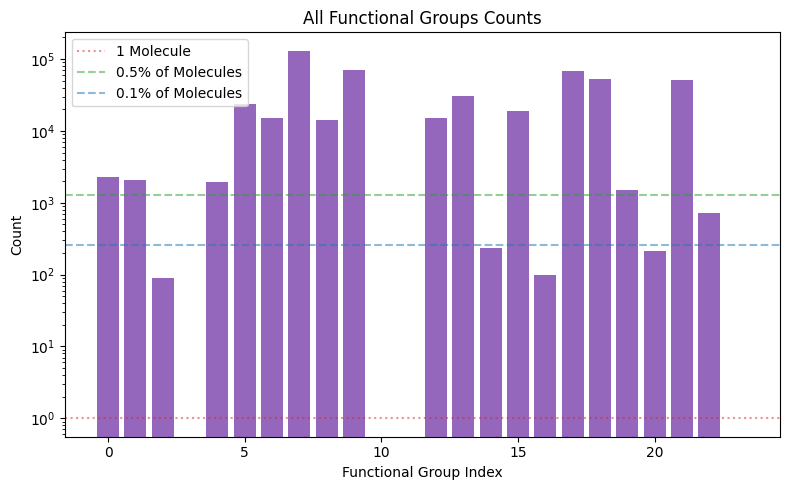

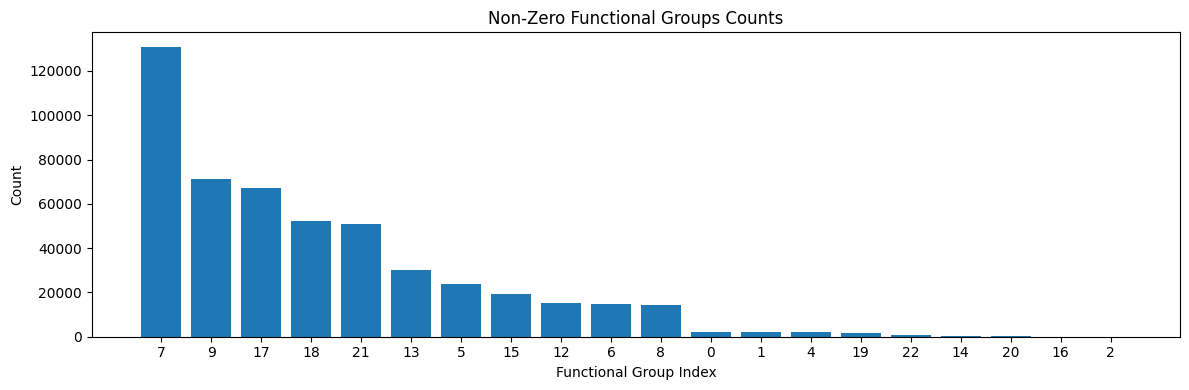

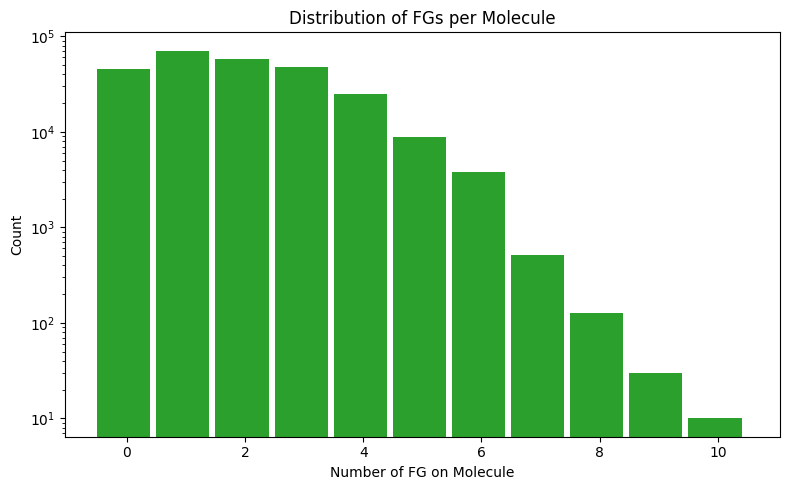

In [11]:
n_fgs = len(fg_to_idx_map)
# n_fgs

fgs = df_mols.to_numpy()[:, 1:]
fgs_counts = fgs.sum(axis=0)
fgs_per_mol = fgs.sum(axis=1)

# Plot for all functional groups
plt.figure(figsize=(8, 5))
plt.bar(np.arange(n_fgs), fgs_counts, color="tab:purple")
plt.axhline(1, color="tab:red", linestyle=":", alpha=0.5, label="1 Molecule")
plt.axhline(smiles.size / 200, color="tab:green", linestyle="--", alpha=0.5, label="0.5% of Molecules")
plt.axhline(smiles.size / 1000, color="tab:blue", linestyle="--", alpha=0.5, label="0.1% of Molecules")
plt.xlabel("Functional Group Index")
plt.ylabel("Count")
plt.yscale("log")
plt.title("All Functional Groups Counts")
plt.legend()
plt.tight_layout()
plt.show()

# Plot for only functional groups which are present 0]
fg_present_counts = fgs_counts[fgs_counts != 0]
order = np.argsort(fg_present_counts)[::-1]
plt.figure(figsize=(12, 4))
plt.bar(np.arange(fg_present_counts.size), fg_present_counts[order], color="tab:blue")
plt.xticks(
    np.arange(fg_present_counts.size),
    [str(i) for i in np.arange(n_fgs)[fgs_counts != 0][order]],
)
plt.xlabel("Functional Group Index")
plt.ylabel("Count")
# plt.yscale("log")
plt.title("Non-Zero Functional Groups Counts")
plt.tight_layout()
plt.show()

# Plot of number of functional group count per molecule
plt.figure(figsize=(8, 5))
plt.hist(fgs_per_mol, bins=np.arange(max(fgs_per_mol) + 1) - 0.5, width=0.9, color="tab:green")
# plt.xticks(np.arange(n_fgs))
plt.xlabel("Number of FG on Molecule")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Distribution of FGs per Molecule")
plt.tight_layout()
plt.show()

## 2.4 Drop Molecules with no functional groups

In [12]:
df_mols.drop(index=np.where(fgs_per_mol == 0)[0], axis=1, inplace=True)
df_mols.reset_index(drop=True, inplace=True)
df_mols

,SMILES,fg_0,fg_1,fg_2,fg_3,fg_4,fg_5,fg_6,fg_7,fg_8,...,fg_14,fg_15,fg_16,fg_17,fg_18,fg_19,fg_20,fg_21,fg_22,fg_23
0,C1=CCNC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,CC1(N)CC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,OC1CNC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,Nc1nnns1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,Nc1nncs1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214223,CN1Cc2c(cc(Br)cc2[N+](=O)[O-])C1=O,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
214224,O=C1CCN(c2cc(C(=O)O)ccc2F)C(=O)N1,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
214225,FC(F)c1ncc2n1CCNC2,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
214226,O=C1CCN(c2cccc(C(=O)O)c2)C(=O)N1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 2.5 Drop Impossible reactions

A reaction is impossible if there are not molecules in the library with a functional group corresponding to that reaction; zero pattern matches will occur and the reaction will never occur.

In [13]:
# Index values of functional groups not present in library
fg_to_drop = np.arange(n_fgs)[fgs_counts == 0]
fg_to_drop = set(fg_to_drop)

# Create list telling whether or not to drop row at that index
drop_idxs = []
for i, fgs in enumerate(df_reactions["functional_groups"]):
    intersect = set(fgs).intersection(fg_to_drop)
    if len(intersect) > 0: 
        drop_idxs.append(i)


# # Drop rows based on calculated condition
# df_reactions = df_reactions.drop(cond)
df_reactions.drop(index=drop_idxs, axis=1, inplace=True)
df_reactions.reset_index(drop=True, inplace=True)
df_reactions

,Unnamed: 0,reaction_name,url,SMARTS,SMARTS_ordered,functional_groups,num_reactants,num_reagents,num_products
0,0,Bartoli Indole Synthesis,http://www.name-reaction.com/bartoli-indole-sy...,"[c]1(-[$([NX3](=[O])=[O]),$([NX3+](=[O])[O-])]...","[C](-[Cl])=[C].[c]1(-[$([NX3](=[O])=[O]),$([NX...","[2, 22]",2,0,1
1,1,Buchwald-Hartwig Amination,http://www.name-reaction.com/buchwald-hartwig-...,"[c]1(-[Cl,Br,I])[c][c][c][c][c]1.[NX3;H2,H1;!$...","[c]1(-[Cl,Br,I])[c][c][c][c][c]1.[NX3;H2,H1;!$...","[15, 18]",2,0,1
2,2,Crossed Claisen Condensation,http://www.name-reaction.com/claisen-condensation,"[C]-[C](=[O])-[O]-[C].[CX4;H1,H2,H3]-[C](=[O])...","[C]-[C](=[O])-[O]-[C].[CX4;H1,H2,H3]-[C](=[O])...","[4, 19]",2,0,1
3,4,Fischer Esterification,http://www.name-reaction.com/fischer-esterific...,[C](=[O])-[OH].[#6;!$(C=O)]-[OH]>>[C](=[O])-[O...,[C](=[O])-[OH].[#6;!$(C=O)]-[OH]>>[C](=[O])-[O...,"[5, 13]",2,0,1
4,5,Fischer Indole Synthesis,http://www.name-reaction.com/fischer-indole-sy...,"[c](-[$([NX3](=[O])=[O]),$([NX3+](=[O])[O-])])...","[C;H1,H2,H3]-[C](=[O]).[c](-[$([NX3](=[O])=[O]...","[9, 22]",2,0,1
5,7,Friedel-Crafts alkylation,http://www.name-reaction.com/friedel-crafts-al...,"[cH]1[c][c][c][c][c]1.[C]-[F,Cl,Br,I]>>[c](-[C...","[C]-[F,Cl,Br,I].[cH]1[c][c][c][c][c]1>>[c](-[C...","[6, 7]",2,0,1
6,9,Knorr pyrazole synthesis,http://www.name-reaction.com/knorr-pyrazole-sy...,"[NX3](-[#6])-[NX3].[C](=[O])-[C;H1,H2]-[C](=[O...","[C](=[O])-[C;H1,H2]-[C](=[O]).[NX3](-[#6])-[NX...","[14, 16]",2,0,1
7,10,amine_acylation_carboxylic_acids,NaN,"[C](=[O])-[OH].[NX3;H2,H1;!$(NC=O)]>>[C](=[O])...","[C](=[O])-[OH].[NX3;H2,H1;!$(NC=O)]>>[C](=[O])...","[5, 18]",2,0,1
8,12,halide_decarboxylation,NaN,"[C]-[C](=[O])-[OH].[#6]-[#9,#17,#35,#53]>>[C]-...","[C]-[C](=[O])-[OH].[#6]-[#9,#17,#35,#53]>>[C]-...","[8, 17]",2,0,1
9,13,SN1_SN2_reaction_alcohols,NaN,"[#6;!$(C=O)]-[OH].[#6]-[#9,#17,#35,#53]>>[#6]-...","[#6;!$(C=O)]-[OH].[#6]-[#9,#17,#35,#53]>>[#6]-...","[13, 17]",2,0,1


### 2.6 *Optional*: Drop reactions by names

In [14]:
# # TODO
# drop_names = [
#     "Bartoli Indole Synthesis",
#     "Fischer Indole Synthesis",
#     "Knorr pyrazole synthesis",
# ]

# # Create list telling whether or not to drop row at that index
# drop_idxs = []
# for i, name in enumerate(df_reactions["reaction_name"]):
#     if name in drop_names:
#         drop_idxs.append(i)

# df_reactions.drop(index=drop_idxs, axis=1, inplace=True)
# df_reactions.reset_index(drop=True, inplace=True)
# df_reactions

### 2.7 *Optional*: Drop reactions with few molecule hits

Here, a minimum number of molecule hits is set for all of the reactant structures, and any reactions with counts below this threshold are dropped. The reasoning behind removing chemical reactions with low number of reactants is that these reactions could produce highly-unique molecules which very few other molecules in the combinatorial synthesis library would be chemically similar to.

In [15]:
# fgs = df_mols.to_numpy()[:, 1:]
# fgs_counts = fgs.sum(axis=0)

# # Set minimum threshold for number of molecules to be considered
# min_threshold = 0.001 * smiles.size  # 0.1% of molecules
# print(f"Minimum threshold: {min_threshold:.2f}")


# drop_idxs = []
# for i, row in df_reactions.iterrows():
#     # Get functional groups
#     fg_idxs = row["functional_groups"]

#     # Get number of molecules with functional groups
#     n_mols = np.asarray([fgs_counts[idx] for idx in fg_idxs])

#     # Check if any of the functional groups have less than the minimum threshold
#     if any(n_mols < min_threshold):
#         drop_idxs.append(i)



# df_reactions.drop(index=drop_idxs, axis=1, inplace=True)
# df_reactions.reset_index(drop=True, inplace=True)
# df_reactions

(0, 'Bartoli Indole Synthesis')

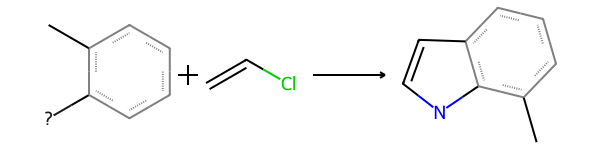

(1, 'Buchwald-Hartwig Amination')

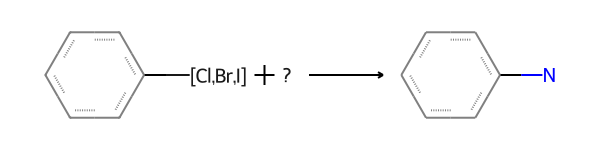

(2, 'Crossed Claisen Condensation')

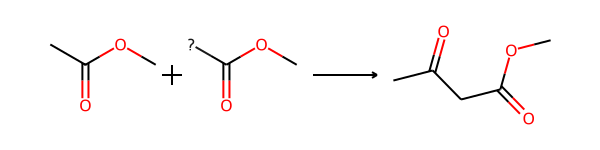

(3, 'Fischer Esterification')

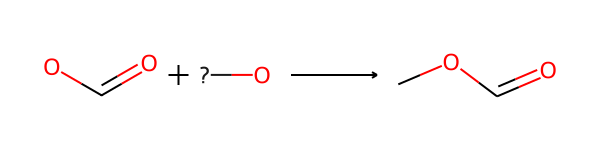

(4, 'Fischer Indole Synthesis')

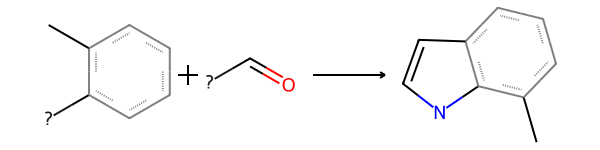

(5, 'Friedel-Crafts alkylation')

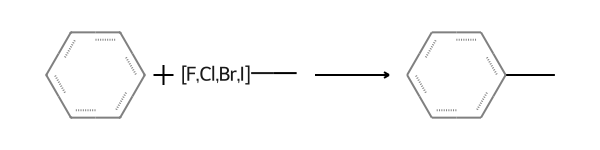

(6, 'Knorr pyrazole synthesis')

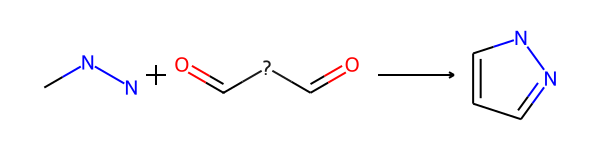

(7, 'amine_acylation_carboxylic_acids')

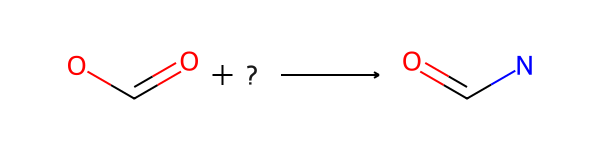

(8, 'halide_decarboxylation')

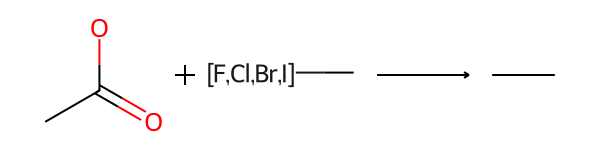

(9, 'SN1_SN2_reaction_alcohols')

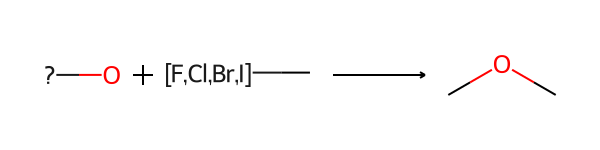

(10, 'SN1_SN2_reaction_amines')

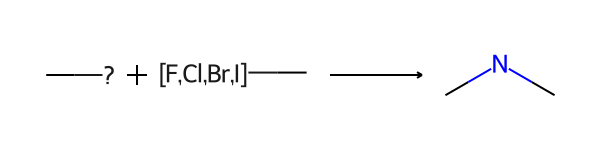

(11, 'alcohol_alkyne_addition')

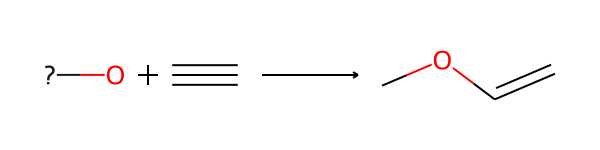

(12, 'carboxylic_acid_alkyne_addition')

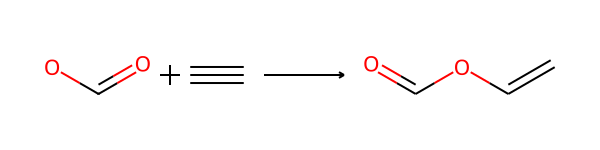

In [16]:
for i, row in df_reactions.iterrows():
    display((i, row["reaction_name"]))
    display(Chem.rdChemReactions.ReactionFromSmarts(row["SMARTS"]))

# 3 Export reactions and molecules as `tsv` files

The CSL-VAE expects reaction rules and molecules to be imported as tab separated values.
Pandas is used to generate a dataframe with relevant information (ID, chemical information, etc) and exported to a `.tsv` file.
Each molecule can have multiple functional groups (R groups), and these value are enumerated by duplicating rows for each molecule (see notes for more details).

<!-- *Note:* Not sure how R groups is set up for Enamine REAL dataset, or exactly how CSL-VAE incorporates it. May have to identify some substructures? -->

In [17]:
rxn_required_columns = ["reaction_id", "num_rgroups", "smarts"]

rxn_df_export = pd.DataFrame()
rxn_df_export["reaction_id"] = [f"rxn_{i}" for i in range(df_reactions.shape[0])]
rxn_df_export["num_rgroups"] = df_reactions["num_reactants"]
rxn_df_export["smarts"] = df_reactions["SMARTS_ordered"]

display(rxn_df_export)

for col in rxn_required_columns:
    assert col in rxn_df_export, f"Column {col} not in rxn_df"

,reaction_id,num_rgroups,smarts
0,rxn_0,2,"[C](-[Cl])=[C].[c]1(-[$([NX3](=[O])=[O]),$([NX..."
1,rxn_1,2,"[c]1(-[Cl,Br,I])[c][c][c][c][c]1.[NX3;H2,H1;!$..."
2,rxn_2,2,"[C]-[C](=[O])-[O]-[C].[CX4;H1,H2,H3]-[C](=[O])..."
3,rxn_3,2,[C](=[O])-[OH].[#6;!$(C=O)]-[OH]>>[C](=[O])-[O...
4,rxn_4,2,"[C;H1,H2,H3]-[C](=[O]).[c](-[$([NX3](=[O])=[O]..."
5,rxn_5,2,"[C]-[F,Cl,Br,I].[cH]1[c][c][c][c][c]1>>[c](-[C..."
6,rxn_6,2,"[C](=[O])-[C;H1,H2]-[C](=[O]).[NX3](-[#6])-[NX..."
7,rxn_7,2,"[C](=[O])-[OH].[NX3;H2,H1;!$(NC=O)]>>[C](=[O])..."
8,rxn_8,2,"[C]-[C](=[O])-[OH].[#6]-[#9,#17,#35,#53]>>[C]-..."
9,rxn_9,2,"[#6;!$(C=O)]-[OH].[#6]-[#9,#17,#35,#53]>>[#6]-..."


In [18]:
rxn_df_export.to_csv("reactions.tsv", sep="\t")

In [19]:
mol_required_columns = ["synthon_id", "reaction_id", "rgroup", "smiles"]
mol_df_export = pd.DataFrame(columns=mol_required_columns)
file_name = "synthons.tsv"
mol_df_export.to_csv("synthons.tsv", sep="\t")


def get_columns_for_single_synthon(idx, smiles, fg_bit_array, rxn_fg_map) -> dict:
    """This method takes in a single index for a synthon (including SMILES string and
    functional group bit array) and construct a dictionary representing this synthons
    column in the larger exported synthon DataFrame.
    
    Arguments:
        (int) idx: Index of synthon in the larger DataFrame
        (str) smiles: SMILES string of synthon
        (np.ndarray) fg_bit_array: Bit array representing which functional groups are
        (dict) rxn_fg_map: Dictionary where keys are reaction labels and values
            are lists of functional groups for that reaction.

    Returns:
        (dict) tmp_dict: Dictionary representing the columns of the synthon DataFrame.
            Columns are ["synthon_id", "reaction_id", "rgroup", "smiles"]
    """
    functional_groups = np.where(fg_bit_array[idx] == 1)[0]
    tmp_reaction_id = []
    tmp_rgroup = []
    for fg in functional_groups:
        # # Single iteration approach, less comprehensible
        # tmp = {rxn_id: fg_id for rxn_id, fg_id in rxn_fg_map.items() if fg in fg_id}

        # Two iteration approach, more comprehensible
        tmp_reaction_id.extend([rxn_id for rxn_id, fg_id in rxn_fg_map.items() if fg in fg_id])
        tmp_rgroup.extend([fg for rxn_id, fg_id in rxn_fg_map.items() if fg in fg_id])

    return {
        "synthon_id": [f"syn_{idx}"] * len(tmp_rgroup),
        "reaction_id": tmp_reaction_id,
        "rgroup": tmp_rgroup,
        "smiles": [smiles] * len(tmp_rgroup)
    }


# NOTE: Method for exporting synthon DataFrame needs to be chunked because of of memory
# constraints for very large molecule datasets.
max_chunk_size = 100_000
synthon_dict = {"synthon_id": [], "reaction_id": [], "rgroup": [], "smiles": []}
fg_bit_array = df_mols.to_numpy()[:, 1:].astype(np.byte)  # exclude SMILES column; reduce memory footprint by using byte type
rxn_fg_map = {f"rxn_{rxn_idx}": rxn_fgs for rxn_idx, rxn_fgs in enumerate(df_reactions["functional_groups"])}

dataframe_idx = 0

for idx, row in tqdm(df_mols.iterrows(), total=df_mols.shape[0]):
# for idx, row in df_mols.iterrows():
    tmp_dict = get_columns_for_single_synthon(
        idx=idx,
        smiles=row["SMILES"],
        fg_bit_array=fg_bit_array,
        rxn_fg_map=rxn_fg_map
    )
    synthon_dict["synthon_id"].extend(tmp_dict["synthon_id"])
    synthon_dict["reaction_id"].extend(tmp_dict["reaction_id"])
    synthon_dict["rgroup"].extend(tmp_dict["rgroup"])
    synthon_dict["smiles"].extend(tmp_dict["smiles"])

    # Check if length is greater than max_chunk_size and export if true
    if len(synthon_dict["synthon_id"]) >= max_chunk_size:
        print("Exporting chunk", dataframe_idx)
        pd.DataFrame.from_dict(synthon_dict).to_csv(file_name, sep="\t", mode="a", header=False)
        synthon_dict = {"synthon_id": [], "reaction_id": [], "rgroup": [], "smiles": []}
        dataframe_idx += 1

print("Exporting chunk", dataframe_idx, "(final chunk)")
pd.DataFrame.from_dict(synthon_dict).to_csv(file_name, sep="\t", mode="a", header=False)

 10%|▉         | 21331/214228 [00:00<00:06, 28006.26it/s]

Exporting chunk 0


 21%|██        | 44125/214228 [00:01<00:06, 26734.20it/s]

Exporting chunk 1


 31%|███       | 66239/214228 [00:02<00:05, 26013.13it/s]

Exporting chunk 2


 48%|████▊     | 102353/214228 [00:04<00:03, 31923.49it/s]

Exporting chunk 3


 64%|██████▍   | 138170/214228 [00:05<00:02, 31576.75it/s]

Exporting chunk 4


 78%|███████▊  | 167688/214228 [00:06<00:01, 30085.11it/s]

Exporting chunk 5


 90%|████████▉ | 192445/214228 [00:08<00:00, 28761.13it/s]

Exporting chunk 6


100%|██████████| 214228/214228 [00:09<00:00, 23524.86it/s]


Exporting chunk 7 (final chunk)
